# ISI-effect on spike

purpose: demonstrate effect of ISI on extracellular spike amplitudes and related features such as spike width during bursting for a subsample of neurons 

Compare ISI on spike features for regular vs. bursting neurons.

Bursting cells (Markram 2015, fig. 11)
- L4PC, L4SP, L4SS
- L5LBC, L5NBC, L5SBC, L5TTPC1, L5TTPC2, L5UTPC, L5STPC, L5BP, 

TPC: thick-tufted pyramidal cells
- cSTUT, bSTUT, dSTUT

ISI within burst ~ 10-20 ms (fig11)

### Setup

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface
import spikeinterface.preprocessing as spre
from spikeinterface.postprocessing import compute_isi_histograms
from ipywidgets import interactive, widgets
import spikeinterface.widgets as sw
import spikeinterface as si
from scipy.spatial.distance import cdist

print(spikeinterface.__version__)

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

matplotlib.rcParams['agg.path.chunksize'] = 10000

# preprocessing parameters
FREQ_MIN = 300
FREQ_MAX = 3000

# recording path
REC_PATH = "dataset/00_raw/recording_npx_evoked"  # full
GT_PATH = "dataset/00_raw/ground_truth_npx_evoked"  # full

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

0.100.5


### Functions

In [15]:

def shorten_waveform(waveforms: np.array, window_to_search_peak_sec=2.5, sampling_freq=20000):

    # calculate shorter window
    sample_sec = (1/sampling_freq) * 1000
    shorter_window = int(window_to_search_peak_sec / sample_sec)

    # get shorter window
    mid_point = int(waveforms.shape[1] / 2 )
    wind_start = int(mid_point - shorter_window/2)
    wind_end =  int(mid_point + shorter_window/2)
    shorter_window_sample = np.arange(wind_start, wind_end, 1).astype(int)
    return waveforms[:, shorter_window_sample], wind_start, wind_end


def align_by_neg_peak_and_crop(waves, sampling_frequency, window_to_search_peak_sec=2.5, window=100, peak_pos=50):
    """
    W: array of shape (n_waveforms, n_samples) e.g. (N, 480)
    window: number of samples in the output window (e.g. 100)
    peak_pos: index in [0, window-1] where the negative peak will be placed (e.g. 50)
    fill_value: value used when the 100-sample window would run beyond the edges
    Returns: array of shape (n_waveforms, window)
    """
    
    # find peak index in shortened waveform
    # shorten waveform to find peak without spike collision
    short_waves, wind_start, wind_end = shorten_waveform(waves, window_to_search_peak_sec=window_to_search_peak_sec, sampling_freq=sampling_frequency)

    num_waves, _ = short_waves.shape
    left = peak_pos
    right = window - left  # number of samples to include to the right of the peak
    aligned = np.full((num_waves, window), np.nan, dtype=short_waves.dtype) # placeholder of nans

    # index of negative peak for each waveform
    trough_idx = np.argmin(short_waves, axis=1)

    # locate peak index in longer waveforms
    trough_idx = trough_idx + wind_start

    # number of timepoints in longer waves
    n_timepoints = waves.shape[1]

    for w_ix in range(num_waves):

        # desired window in original signal: [p-left, p+right)
        src_start = max(0, trough_idx[w_ix] - left)
        src_end   = min(n_timepoints, trough_idx[w_ix] + right)
        
        # where to place it in the output (shift if we clipped at edges)
        dst_start = max(0, left - trough_idx[w_ix])          # how many samples we clipped on the left
        dst_end   = dst_start + (src_end - src_start)

        # align
        aligned[w_ix, dst_start:dst_end] = waves[w_ix, src_start:src_end]
    return aligned


def distinct_greys(N):
    # values from black (0) to white (1)
    vals = np.linspace(0, 1, N)
    # return as RGB triples
    return np.stack([vals, vals, vals], axis=1)


def distinct_cmap(cmap_name, N):
    cmap = plt.cm.get_cmap(cmap_name, N)  # sample N discrete colors
    return [cmap(i) for i in range(N)]


def plot_burst_spikes(Recording, Gtruth, sfreq, burst, b_unit, peak_pos, window, ms_before, ms_after):
    
    burst_start = burst[0]
    burst_end = burst[1]

    start_frame = int(burst_start * sfreq)
    end_frame = int(burst_end * sfreq)

    unit_spike_frames = Gtruth.get_unit_spike_train(b_unit)
    burst_frames_loc = (start_frame <= unit_spike_frames) & (end_frame >= unit_spike_frames)
    burst_frames = unit_spike_frames[burst_frames_loc]
    n_b_spikes = len(burst_frames)

    # plot burst spikes
    # - find nearest electrode
    site_ids = Recording.get_channel_ids()
    sites_coord = Recording.get_channel_locations(axes='xyz')
    b_unit_loc = np.where(Gtruth.unit_ids == b_unit)[0][0]
    units_coord = np.array([Gtruth.get_property('x'), Gtruth.get_property('y'), Gtruth.get_property('z')]).T
    b_unit_coord = units_coord[b_unit_loc,:]
    dist_matrix = cdist(b_unit_coord[None], sites_coord) 
    closest_site = np.argmin(dist_matrix)
    print('closest site id:', site_ids[closest_site])

    # plot voltage trace during burst
    plt.figure(figsize=(20,2))
    frames_before = 100
    frames_after = 100
    bursting_trace = Recording.get_traces(start_frame=start_frame-frames_before, end_frame=end_frame + frames_after, channel_ids=[site_ids[closest_site]])
    plt.plot(bursting_trace)
    plt.plot(frames_before + burst_frames - burst_frames[0], np.zeros(len(burst_frames)),'o')

    # plot spike waveforms within burst
    plt.figure(figsize=(3,2))

    #colors = distinct_greys(n_b_spikes + 2)
    colors = distinct_cmap("hot", n_b_spikes + 2)

    # - loop over spikes timestamp
    waves = []
    for s_i, b_frame in enumerate(burst_frames):
        wave = Recording.get_traces(start_frame=burst_frames[s_i]-frames_before, end_frame=burst_frames[s_i] + frames_after, channel_ids=[site_ids[closest_site]])
        waves.append(wave)
    waves = np.array(waves).squeeze()

    aligned_waves = align_by_neg_peak_and_crop(np.array(waves), sfreq, window_to_search_peak_sec=2.5, window=window, peak_pos=peak_pos)

    for w_i, wave in enumerate(aligned_waves):
        plt.plot(wave, color=colors[w_i], label=f'spike {w_i}', linewidth=1)

    plt.xticks([0, peak_pos, window], [-ms_before, 0, ms_after])
    plt.legend(bbox_to_anchor=(1.05, 1));
    plt.xlabel('Time (ms)')

## Load dataset

In [6]:
%%time

# load
Recording = si.load_extractor(REC_PATH)

# preprocess
Recording = spre.astype(Recording, "int16")
Recording = spre.bandpass_filter(Recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
Recording = spre.common_reference(Recording, reference="global", operator="median")
Recording = spre.whiten(Recording, dtype='float32') # requires float

sfreq = Recording.get_sampling_frequency()
nframes = Recording.get_num_frames()

CPU times: user 5.74 s, sys: 6.66 s, total: 12.4 s
Wall time: 2.39 s


In [7]:
# Load ground truth and select bursting mtypes 
Gtruth = si.load_extractor(GT_PATH)
mtypes = Gtruth.get_property("mtype")
etypes = Gtruth.get_property("etype")
unit_ids = Gtruth.unit_ids

### Compute ISI hist

In [8]:
# select units 
# loc = (np.char.find(mtypes, "L5") >= 0) & (np.char.find(mtypes, "LBC") >= 0)
# loc = (np.char.find(mtypes, "L5") >= 0) & (np.char.find(mtypes, "NBC") >= 0)
# loc = (np.char.find(mtypes, "L5") >= 0) & (np.char.find(mtypes, "SBC") >= 0)
# loc = (np.char.find(mtypes, "L5") >= 0) & (np.char.find(mtypes, "TPC") >= 0)
# loc = (np.char.find(mtypes, "L5") >= 0) & (np.char.find(mtypes, "STUT") >= 0)
# loc = (etypes=="cSTUT") | (etypes=="bSTUT") | (etypes=="dSTUT") # mtypes: LBC and NBC
# loc = (etypes=="cSTUT") | (etypes=="bSTUT") | (etypes=="dSTUT") | (np.char.find(mtypes, "LBC") >= 0) | (np.char.find(mtypes, "NBC") >= 0) | (np.char.find(mtypes, "SBC") >= 0) | (np.char.find(mtypes, "NTC") >= 0)

# # check whether cell is there
# if not any(loc):
#     raise ValueError("No cell found")
# else:
#     print('number of cells found:', sum(loc))
#     print('their etype:', etypes[loc])
#     print('their mtype:', mtypes[loc])

# unit_ids = np.unique(Gtruth.unit_ids[loc])
# Gtruth = Gtruth.select_units(unit_ids)

# Compute ISI
isi_histogram, bins =  compute_isi_histograms(Gtruth,
                                              window_ms=1000, # 10000: between 0 and 10 seconds ISI
                                              bin_ms=1.0,
                                              method="auto")

### plot ISI hist

1389217, 3477831; 3583934

2204240

In [ ]:
# # plot interactively (one unit at a time)
# def update_plot(cell_ix):
#     plt.plot(isi_histogram[cell_ix,:])
#     plt.xlabel('ISI (ms)')
#     print('unit id:', Gtruth.unit_ids[cell_ix])
#     print("n spikes:", len(Gtruth.get_unit_spike_train(unit_id=Gtruth.unit_ids[cell_ix])))
#     print("n spikes within window:", isi_histogram[cell_ix,:].sum())

# # get slider's value interactively
# slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(Gtruth.unit_ids) - 1,
#     step=1,
#     disabled=False,
#     continuous_update=False,
#     orientation="horizontal",
#     readout=True,
#     readout_format="d",
# )

# # plot interactively
# interactive(update_plot, cell_ix=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='cell_ix', max=1835), Output()),…

### plot Raster

In [10]:
# plot units, time chunks by time chunks
plt.figure(figsize=(20,10))

# fixed window length (seconds)
window_length = 1 # as  in fig11, Markram 2015

# total duration in seconds (from the recording associated with Gtruth)
total_duration_s = nframes / sfreq

# slider for start time
start_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=total_duration_s - window_length,
    step=window_length/3,
    description='Start (s):',
    continuous_update=False,
    layout={'width': '800px'}
)

def update_plot_all_units(start):
    """interactive raster plot

    Args:
        start (_type_): _description_
    """
    time_range = (start, start + window_length)
    sw.plot_rasters(Gtruth, unit_ids=unit_ids, time_range=time_range, figsize=(3,6));

out = widgets.interactive_output(update_plot_all_units, {'start': start_slider})
display(start_slider, out)

<Figure size 2000x1000 with 0 Axes>

FloatSlider(value=0.0, continuous_update=False, description='Start (s):', layout=Layout(width='800px'), max=36…

Output()

In [11]:
# plot units, unit chunks by unit chunks

# fixed window length (seconds)
unit_range = 50             # as in fig11, Markram 2015

# slider for start time
start_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=len(unit_ids) - unit_range,
    step=unit_range,
    description='Start (s):',
    continuous_update=False,
    layout={'width': '800px'}
)

def update_plot(unit_start):
    """interactive raster plot

    Args:
        start (_type_): _description_
    """
    time_range = (0, 1)
    unit_ix = np.arange(unit_start, unit_start + unit_range, 1).astype(int)
    sw.plot_rasters(Gtruth, unit_ids=unit_ids[unit_ix], time_range=time_range, figsize=(3,6));

out = widgets.interactive_output(update_plot, {'unit_start': start_slider})
display(start_slider, out)

FloatSlider(value=0.0, continuous_update=False, description='Start (s):', layout=Layout(width='800px'), max=17…

Output()

In [ ]:
def find_bursts_isi(spike_times, isi_threshold=0.01, min_spikes=3, min_duration=0.02):
    """
    Find bursts based on inter-spike interval (ISI) criterion.
    
    Parameters:
    spike_times: array-like, spike timestamps in seconds
    isi_threshold: float, maximum ISI within burst (seconds)
    min_spikes: int, minimum number of spikes to constitute a burst
    min_duration: float, minimum burst duration (seconds)
    
    Returns:
    list of tuples: [(burst_start, burst_end, n_spikes, burst_duration), ...]
    """
    if len(spike_times) < min_spikes:
        return []
    
    spike_times = np.array(spike_times)
    spike_times = np.sort(spike_times)  # ensure sorted
    
    # Calculate inter-spike intervals
    isis = np.diff(spike_times)
    
    # Find potential burst boundaries
    # Spikes are in same burst if ISI < threshold
    in_burst = isis < isi_threshold
    
    # find burst start and end indices
    burst_starts = []
    burst_ends = []
    
    i = 0
    while i < len(in_burst):
        if in_burst[i]:  # Start of potential burst
            burst_start_idx = i
            
            # Find end of burst
            while i < len(in_burst) and in_burst[i]:
                i += 1
            burst_end_idx = i  # One past the last spike in burst
            
            # Check if this burst meets criteria
            n_spikes_in_burst = burst_end_idx - burst_start_idx + 1
            burst_duration = spike_times[burst_end_idx] - spike_times[burst_start_idx]
            
            if n_spikes_in_burst >= min_spikes and burst_duration >= min_duration:
                burst_starts.append(burst_start_idx)
                burst_ends.append(burst_end_idx)
        else:
            i += 1
    
    # extract burst information
    bursts = []
    for start_idx, end_idx in zip(burst_starts, burst_ends):
        burst_start_time = spike_times[start_idx]
        burst_end_time = spike_times[end_idx]
        n_spikes = end_idx - start_idx + 1
        duration = burst_end_time - burst_start_time
        
        bursts.append((burst_start_time, burst_end_time, n_spikes, duration))
    
    return bursts


def test_find_bursts_isi():
    
    # setup burst parameters
    isi_threshold_sec = 0.015 
    min_spikes = 4
    
    # create test spike timestamps with two bursts of 5 and 7 spikes
    test_spikes_sec = np.sort(np.hstack([np.arange(0,100,1), 10.01, 10.02, 10.03, 10.04, 80, 80.01, 80.02, 80.03, 80.04, 80.05]))
    assert find_bursts_isi(test_spikes_sec, isi_threshold=isi_threshold_sec, min_spikes=min_spikes)==[(10.0, 10.04, 5, 0.03999999999999915), (80.0, 80.05, 7, 0.04999999999999716)], "wrong"



Unit '506676' has 63 bursts with at least a minimum of 4 spikes (thres: 20 ms), but poor SNR

bursting units: ['506676' '2281009' '3972082']
number of bursts: 59
closest site id: 63
CPU times: user 573 ms, sys: 766 ms, total: 1.34 s
Wall time: 272 ms


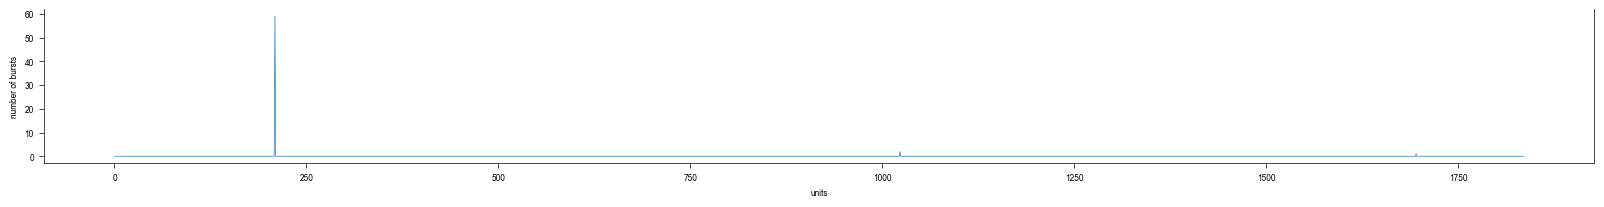

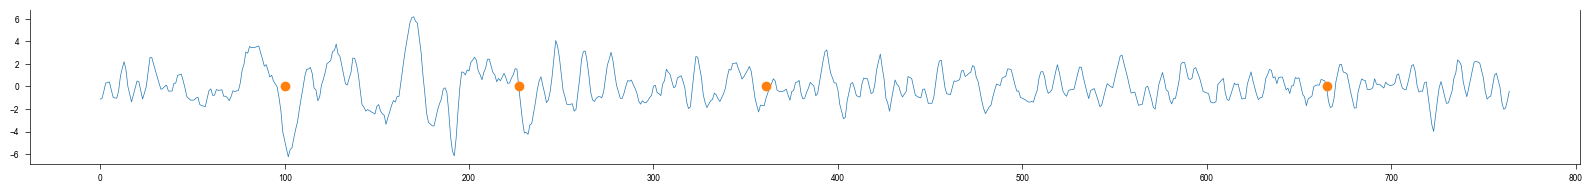

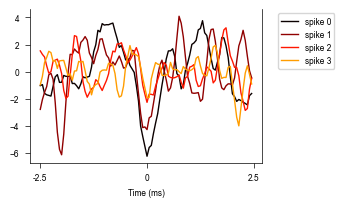

In [19]:
%%time 

# find bursting units ------------------------------------------------------------
# setup burst parameters
min_spikes = 3           # minimum spike in burst ((min=2 max 4 as in Allen BD)
isi_thresh_sec = 0.020   # (default=20 ms as in Allen BD, 2020, JN)

# find bursts
bursts = dict()
n_bursts = []
for unit in unit_ids:
    spike_ttp_secs = Gtruth.get_unit_spike_train(unit) / sfreq # timestamps in seconds
    burst = find_bursts_isi(spike_ttp_secs, isi_threshold=isi_thresh_sec, min_spikes=min_spikes)
    n_bursts.append(len(burst))
    bursts[unit] = burst

# unit-test
test_find_bursts_isi()

# plot number of bursts by cell
plt.figure(figsize=(20,2))
plt.plot(n_bursts)
plt.ylabel('number of bursts')
plt.xlabel('units')

# find bursting unit ids
bursting_units = unit_ids[np.where(np.array(n_bursts) > 0)[0]]
print('bursting units:', bursting_units)

# find samples of the burst spikes ------------------------------------------------------------
b_unit = '506676'   # bursting unit
b_ix = 6            # burst index

frames_before = 30   # add 1.5 ms at 20 KHz
frames_after = 30    # add 1.5 ms at 20 KHz
MS_BEFORE = 2.5
MS_AFTER = 2.5
WINDOW = 100
PEAK_POS = 50

print('number of bursts:', len(bursts[b_unit]))

plot_burst_spikes(Recording, Gtruth, sfreq, bursts[b_unit][b_ix], b_unit, PEAK_POS, WINDOW, MS_BEFORE, MS_AFTER)

NameError: name 'sites_coord' is not defined

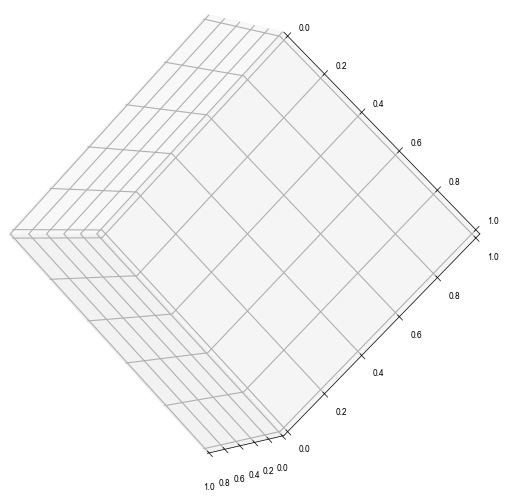

In [14]:
# validate unit and electrode locations 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(70, 45, 90)  # elevation=30°, azimuth=45°
ax.scatter(sites_coord[:,0], sites_coord[:,1], sites_coord[:,2], c='blue', cmap='viridis', s=1)
ax.scatter(b_unit_coord[0], b_unit_coord[1], b_unit_coord[2], c='red', cmap='viridis', s=20)